In [1]:
import sys 
sys.path.append("../..")
import pandas as pd 
import geopandas as gpd
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx
from src.bagData import BagData, create_tensorflow_iterator, create_bag_multiresolution_dictionary
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import gpflow 
from scipy.stats import sem
import json
import random 
import time 
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from src.svgp import MVBAgg
from src.util import optimize_adam, optimize_natgrad_adam, save_model, load_model
from src.plot_util import create_pixel_square,create_point
from sklearn.cluster import KMeans
seed = 0

# read in user-specified counties and states to study
dates = ['04-07']
counties_states = pd.read_csv("../../data/crops/counties-states.csv")
States = ["OHIO","ILLINOIS", "IOWA", "MICHIGAN", "MISSOURI", "NORTH DAKOTA", "SOUTH DAKOTA"]
col_latlon = ["longitude", "latitude"]
col_modis = [f"EVI_{date}" for date in dates]
col_gridmet = [f"pr_{date}" for date in dates] + [f"tmmx_{date}" for date in dates]

# read in latlon
df_latlon = pd.read_csv("../../data/crops/processed_covariates/latlon-500_data_500points.csv")
df_latlon["key"] = df_latlon["County"] + "-" + df_latlon["State"]
df_latlon = df_latlon[df_latlon["key"].isin(counties_states["key"])]
df_latlon = df_latlon.drop_duplicates(["County", "State", "longitude", "latitude"])

# read in and take subset of features data
df_modis = pd.read_csv("../../data/crops/processed_covariates/MOD13Q1-1000_data.csv")
df_modis = df_modis[df_modis["year"]==2015]
df_modis["key"] = df_modis["County"] + "-" + df_modis["State"]
df_modis = df_modis[df_modis["key"].isin(counties_states["key"])]
features = ["year", "key", "County", "State", "longitude", "latitude"] + [f"EVI_{date}" for date in dates]
df_modis = df_modis[features]
df_modis = df_modis.dropna()
df_modis = df_modis.drop_duplicates(["County", "State", "longitude", "latitude", "year"])


# read in and take subset of features data
df_gridmet = pd.read_csv("../../data/crops/processed_covariates/GRIDMET_data.csv")
df_gridmet = df_gridmet[df_gridmet["year"]==2015]
df_gridmet["key"] = df_gridmet["County"] + "-" + df_gridmet["State"]
df_gridmet = df_gridmet[df_gridmet["key"].isin(counties_states["key"])]
features = ["key", "year", "County", "State", "longitude", "latitude"] + col_gridmet
df_gridmet = df_gridmet[features]
df_gridmet = df_gridmet.drop_duplicates(["County", "State", "longitude", "latitude", "year"])

df_response = pd.read_csv("../../data/synthetic/synthetic_yields.csv")

kf = KFold(n_splits=5, random_state=seed, shuffle=True)
output_types=(
    tf.int64, 
    tf.int64, 
    tf.int64, 
    tf.int64, 
    tf.float64, 
    tf.float64, 
    tf.float64, 
    tf.float64, 
    tf.float64, 
    tf.float64, 
    tf.float64, 
    tf.float64, 
    tf.float64
)
keys = list(set(df_response.key))
keys.sort()


RMSE = []
MAPE  = []
LL  = []
training_time = []
iterations = 20000
lr_adam = 0.001
num_minibatch = 50
latlon_cols = ["longitude", "latitude"]
modis_cols = [f"EVI_{date}" for date in dates]
pr_cols = [f"pr_{date}" for date in dates] 
tmmx_cols = [f"tmmx_{date}" for date in dates] 
all_features = latlon_cols + modis_cols + pr_cols + tmmx_cols
num_resolutions = 4
# write down index of the features
col_index_space = [0, 1]
col_index_modis = [2]
col_index_pr = [3]
col_index_tmmx = [4]
# col_index_all = col_index_space + col_index_modis + col_index_pr + col_index_tmmx
max_pixels = [500, 100, 100, 100]


In [2]:
for fold, (train_index, test_index) in tqdm(enumerate(kf.split(keys))):
    df_Z = pd.read_csv(f"../../data/crops/processed_covariates/df_Z_MVBAgg_fold{fold}.csv")
    train_keys = [keys[key] for key in train_index]
    test_keys = [keys[key] for key in test_index]
    Z = df_Z[df_Z["key"].isin(train_keys)][all_features].values
    
    X_latlon_train = df_latlon[df_latlon["key"].isin(train_keys)].loc[:, latlon_cols].values
    X_latlon_test = df_latlon[df_latlon["key"].isin(test_keys)].loc[:, latlon_cols].values
    X_modis_train = df_modis[df_modis["key"].isin(train_keys)].loc[:, modis_cols].values
    X_modis_test = df_modis[df_modis["key"].isin(test_keys)].loc[:, modis_cols].values
    X_pr_train = df_gridmet[df_gridmet["key"].isin(train_keys)].loc[:, pr_cols].values
    X_pr_test = df_gridmet[df_gridmet["key"].isin(test_keys)].loc[:, pr_cols].values
    X_tmmx_train = df_gridmet[df_gridmet["key"].isin(train_keys)].loc[:, tmmx_cols].values
    X_tmmx_test = df_gridmet[df_gridmet["key"].isin(test_keys)].loc[:, tmmx_cols].values
    y_train = df_response[df_response["key"].isin(train_keys)].y.values[:, None]
    y_test = df_response[df_response["key"].isin(test_keys)].y.values[:, None]

    scaler_y = StandardScaler().fit(y_train)
    y_train = scaler_y.transform(y_train)

    scaler_latlon = StandardScaler().fit(X_latlon_train)
    X_latlon_train = scaler_latlon.transform(X_latlon_train)
    X_latlon_test = scaler_latlon.transform(X_latlon_test)
    # Z[:, col_index_space] = scaler_x.transform(Z[:, col_index_space])
    
    scaler_modis = StandardScaler().fit(X_modis_train)
    X_modis_train = scaler_modis.transform(X_modis_train)
    X_modis_test = scaler_modis.transform(X_modis_test)
    # Z[:, col_index_modis] = scaler_x.transform(Z[:, col_index_modis])

    scaler_pr = StandardScaler().fit(X_pr_train)
    X_pr_train = scaler_pr.transform(X_pr_train)
    X_pr_test = scaler_pr.transform(X_pr_test)
    # Z[:, col_index_pr] = scaler_x.transform(Z[:, col_index_pr])
    
    scaler_tmmx = StandardScaler().fit(X_tmmx_train)
    X_tmmx_train = scaler_tmmx.transform(X_tmmx_train)
    X_tmmx_test = scaler_tmmx.transform(X_tmmx_test)
    # Z[:, col_index_tmmx] = scaler_x.transform(Z[:, col_index_tmmx])

    df_features_list = [df_latlon, df_modis, df_gridmet, df_gridmet]
    # df_features_list = [df_modis[df_modis["year"]==2015], df_modis[df_modis["year"]==2015], df_gridmet[df_gridmet["year"]==2015], df_gridmet[df_gridmet["year"]==2015]]

    train_dict = create_bag_multiresolution_dictionary(
        [X_latlon_train, X_modis_train, X_pr_train, X_tmmx_train], 
        # [X_latlon_train, X_modis_train, X_tmmx_train], 
        y_train, 
        [df_features[df_features["key"].isin(train_keys)] for df_features in df_features_list],
        df_response[df_response["key"].isin(train_keys)],
        train_keys,
        max_pixels
    )
    # df_features_list = [df_modis[df_modis["year"]==2017], df_modis[df_modis["year"]==2017], df_gridmet[df_gridmet["year"]==2017], df_gridmet[df_gridmet["year"]==2017]]
    test_dict = create_bag_multiresolution_dictionary(
        [X_latlon_test, X_modis_test, X_pr_test, X_tmmx_test], 
        # [X_latlon_test, X_modis_test, X_tmmx_test], 
        y_test, 
        [df_features[df_features["key"].isin(test_keys)] for df_features in df_features_list],
        df_response[df_response["key"].isin(test_keys)],
        test_keys,
        max_pixels
    )

    train_bags = BagData(bag_data=train_dict, bags_metadata=train_keys)
    test_bags = BagData(bag_data=test_dict, bags_metadata=test_keys)

    # ds_train = create_tensorflow_iterator(train_bags.gen_bags, output_types=output_types)


    # fit and train GP regression model
    k_space = gpflow.kernels.Matern32(active_dims=col_index_space)
    k_modis = gpflow.kernels.RBF(active_dims=col_index_modis)
    k_pr = gpflow.kernels.RBF(active_dims=col_index_pr)
    k_tmmx = gpflow.kernels.RBF(active_dims=col_index_tmmx)

    # k = k_space + k_modis + k_tmmx
    k = k_space + k_modis + k_pr + k_tmmx
    m = MVBAgg(kernel=k, likelihood=gpflow.likelihoods.Gaussian(), inducing_variable=Z, num_resolution=num_resolutions, num_data=train_bags.num_bags)
    gpflow.set_trainable(m.inducing_variable, False)
    
    # print("Begin Training")
    # t0 = time.time()
    # logf = optimize_natgrad_adam(m, ds_train, num_data=train_bags.num_bags, iterations=iterations, minibatch_size=num_minibatch, learning_rate=lr_adam)
    # t1 = time.time()
    # save_model(m, save_path="../../results/synthetic", model_name=f"MVBAgg_fold{fold}")
    load_model(m, f"../../results/synthetic/MVBAgg_fold{fold}.pickle")

    break

100%|██████████| 77/77 [00:00<00:00, 305.83it/s]
2022-01-14 14:02:43.378395: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-14 14:02:43.378451: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nvidia4
2022-01-14 14:02:43.378457: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nvidia4
2022-01-14 14:02:43.378602: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2022-01-14 14:02:43.378623: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2022-01-14 14:02:43.378628: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2022-01-14 14:02:43.379929: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (on

In [3]:
x_modis_original = scaler_modis.transform(df_modis[["EVI_04-07"]].values)
x_modis = np.linspace(-5, 5, 100)[:, None]
f_mean_modis, f_var_modis = m.predict_f_i(x_modis, 1)

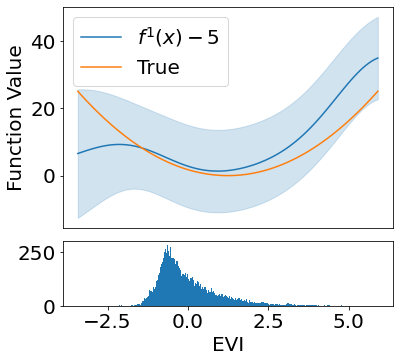

In [4]:
from matplotlib.gridspec import GridSpec
pars = {"size": 20}
plt.rc("font", **pars)
fig = plt.figure(figsize=(8, 5.5))
gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[0:3,0:3])
ax_marg_x = fig.add_subplot(gs[3,0:3])
ax_joint.plot(x_modis, scaler_y.inverse_transform(f_mean_modis)-5, label="$f^1(x) - 5$")
ax_joint.fill_between(
    x_modis[:,0],
    scaler_y.inverse_transform(f_mean_modis - 1.96 * np.sqrt(f_var_modis))[:, 0]-5,
    scaler_y.inverse_transform(f_mean_modis + 1.96 * np.sqrt(f_var_modis))[:, 0]-5,
    color="C0",
    alpha=0.2,
)
ax_joint.plot(x_modis, x_modis**2, label="True") # note the constant bias
ax_joint.legend()
ax_joint.get_xaxis().set_ticks([])
ax_joint.set_ylabel("Function Value")
ax_marg_x.hist(x_modis_original, bins=1000)
ax_marg_x.set_xlabel("EVI")
plt.savefig("../../results/synthetic/EVI_disagg.pdf")

In [129]:
x_pr_original = scaler_pr.transform(df_gridmet[["pr_04-07"]].values)
x_pr_plot = np.linspace(-5, 12, 100)[:, None]
f_mean, f_var = m.predict_f_i(x_pr_plot, 2)

In [130]:
x_pr_original.min()

-0.8051831395055279

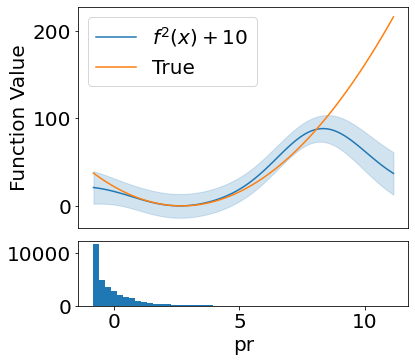

In [131]:
from matplotlib.gridspec import GridSpec
pars = {"size": 20}
plt.rc("font", **pars)
fig = plt.figure(figsize=(8, 5.5))
gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[0:3,0:3])
ax_marg_x = fig.add_subplot(gs[3,0:3])
constant_bias = -10
ax_joint.plot(x_pr_plot, scaler_y.inverse_transform(f_mean)-constant_bias, label=f"$f^2(x) + 10$")
ax_joint.fill_between(
    x_pr_plot[:,0],
    scaler_y.inverse_transform(f_mean - 1.96 * np.sqrt(f_var))[:, 0]-constant_bias,
    scaler_y.inverse_transform(f_mean + 1.96 * np.sqrt(f_var))[:, 0]-constant_bias,
    color="C0",
    alpha=0.2,
)
ax_joint.plot(x_pr_plot, 1.5*x_pr_plot**2, label="True") # note the constant bias
ax_joint.legend()
ax_joint.get_xaxis().set_ticks([])
ax_joint.set_ylabel("Function Value")
ax_marg_x.hist(x_pr_original, bins=50)
ax_marg_x.set_xlabel("pr")
plt.savefig("../../results/synthetic/pr_disagg.pdf")

In [132]:
x_tmmx_original = scaler_tmmx.transform(df_gridmet[["tmmx_04-07"]].values)
x_tmmx_plot = np.linspace(-2, 2, 100)[:, None]
f_mean, f_var = m.predict_f_i(x_tmmx_plot, 3)

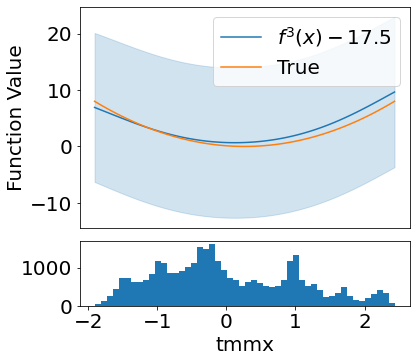

In [133]:
from matplotlib.gridspec import GridSpec
pars = {"size": 20}
plt.rc("font", **pars)
fig = plt.figure(figsize=(8, 5.5))
gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[0:3,0:3])
ax_marg_x = fig.add_subplot(gs[3,0:3])
constant_bias = 17.5
ax_joint.plot(x_tmmx_plot, scaler_y.inverse_transform(f_mean)-constant_bias, label=f"$f^3(x) - 17.5$")
ax_joint.fill_between(
    x_tmmx_plot[:,0],
    scaler_y.inverse_transform(f_mean - 1.96 * np.sqrt(f_var))[:, 0]-constant_bias,
    scaler_y.inverse_transform(f_mean + 1.96 * np.sqrt(f_var))[:, 0]-constant_bias,
    color="C0",
    alpha=0.2,
)
ax_joint.plot(x_tmmx_plot, 2*x_tmmx_plot**2, label="True") # note the constant bias
ax_joint.legend()
ax_joint.get_xaxis().set_ticks([])
ax_joint.set_ylabel("Function Value")
ax_marg_x.hist(x_tmmx_original, bins=50)
ax_marg_x.set_xlabel("tmmx")
plt.savefig("../../results/synthetic/tmmx_disagg.pdf")

In [136]:
error.mean()

2.110926493259511

## VBAgg

In [5]:
from src.bagData import create_bag_sameresolution_dictionary
from src.svgp import VBagg
seed = 0

# %%
# read in user-specified counties and states to study
counties_states = pd.read_csv("../../data/crops/counties-states.csv")
dates = ['04-07']

# read in and take subset of yield data
df_response = pd.read_csv("../../data/synthetic/synthetic_yields.csv")
df_response = df_response[df_response["key"].isin(counties_states["key"])]

# read in and take subset of features data
df_features = pd.read_csv("../../data/crops/processed_covariates/MOD13Q1-GRIDMET-downsampled_data.csv")
df_features["key"] = df_features["County"] + "-" + df_features["State"]
df_features = df_features[df_features["key"].isin(counties_states["key"])]
df_features = df_features[df_features["year"]==2015]

# dates of the features
features = ["key", "County", "State", "year", "longitude", "latitude"] + [f"EVI_{date}" for date in dates] + [f"pr_{date}" for date in dates] + [f"tmmx_{date}" for date in dates]
df_features = df_features[features]
df_features = df_features.drop_duplicates(["County", "State", "year", "longitude", "latitude"])

# %%
# write down index of the features
col_index_space = [0, 1]
col_index_modis = [2]
col_index_pr = [3]
col_index_tmmx = [4]
col_index_all = col_index_space + col_index_modis + col_index_pr + col_index_tmmx

# %% [markdown]
# ## Experimental Setup

kf = KFold(n_splits=5, random_state=seed, shuffle=True)
output_types=(
    tf.int64, 
    tf.float64, 
    tf.float64, 
    tf.float64
)
keys = list(set(df_response.key))
keys.sort()

# %% [markdown]
# Now we create a dictionary in the required format of src.bagData.bagData

# %%
RMSE = []
MAPE  = []
LL  = []
training_time = []
iterations = 20000
num_minibatch = 50
lr_adam = 0.001
max_pixels = 100
latlon_cols = ["longitude", "latitude"]
modis_cols = [f"EVI_{date}" for date in dates]
pr_cols = [f"pr_{date}" for date in dates] 
tmmx_cols = [f"tmmx_{date}" for date in dates] 
all_features = latlon_cols + modis_cols + pr_cols + tmmx_cols

for fold, (train_index, test_index) in tqdm(enumerate(kf.split(keys))):
    train_keys = [keys[key] for key in train_index]
    test_keys = [keys[key] for key in test_index]
    X_train = df_features.loc[(df_features["key"].isin(train_keys)), all_features].values
    X_test = df_features.loc[(df_features["key"].isin(test_keys)), all_features].values
    y_train = df_response[(df_response["key"].isin(train_keys))].y.values[:, None]
    y_test = df_response[(df_response["key"].isin(test_keys))].y.values[:, None]

    scaler_x = StandardScaler().fit(X_train)
    scaler_y = StandardScaler().fit(y_train)
    X_train, y_train = scaler_x.transform(X_train), scaler_y.transform(y_train)
    X_test = scaler_x.transform(X_test)

    train_dict = create_bag_sameresolution_dictionary(
        X_train, 
        y_train, 
        df_features[(df_features["key"].isin(train_keys))],
        df_response[(df_response["key"].isin(train_keys))],
        train_keys,
        max_pixels
    )
    test_dict = create_bag_sameresolution_dictionary(
        X_test, 
        y_test, 
        df_features[(df_features["key"].isin(test_keys))],
        df_response[(df_response["key"].isin(test_keys))],
        test_keys,
        max_pixels
    )

    train_bags = BagData(bag_data=train_dict, bags_metadata="train")
    test_bags = BagData(bag_data=test_dict, bags_metadata="test")

    ds_train = create_tensorflow_iterator(train_bags.gen_bags, output_types=output_types)

    # create inducing points
    kmeans = KMeans(1)
    Z = np.zeros((train_bags.num_bags, len(col_index_all)))
    for i, bag in enumerate(train_bags.bags):
        data = train_bags[bag]
        Z_tmp = kmeans.fit(data[2]).cluster_centers_
        Z[i] = Z_tmp

    # fit and train GP regression model
    k_space = gpflow.kernels.Matern32(active_dims=col_index_space)
    k_modis = gpflow.kernels.RBF(active_dims=col_index_modis)
    k_pr = gpflow.kernels.RBF(active_dims=col_index_pr)
    k_tmmx = gpflow.kernels.RBF(active_dims=col_index_tmmx)
    k = k_space + k_modis + k_pr + k_tmmx
    m = VBagg(kernel=k, likelihood=gpflow.likelihoods.Gaussian(), inducing_variable=Z,num_data=train_bags.num_bags)
    gpflow.set_trainable(m.inducing_variable, False)
    
    load_model(m, f"../../results/synthetic/VBagg_fold{fold}.pickle")
    break 

100%|██████████| 77/77 [00:00<00:00, 2055.13it/s]
0it [00:02, ?it/s]


In [6]:
x_tmmx_original = X_train[:,4]
x_pr_plot = np.linspace(-1, 12, 100)[:, None]
f_mean, f_var = m.predict_f_i(x_tmmx_plot, 3)
from matplotlib.gridspec import GridSpec
pars = {"size": 20}
plt.rc("font", **pars)
fig = plt.figure(figsize=(8, 5.5))
gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[0:3,0:3])
ax_marg_x = fig.add_subplot(gs[3,0:3])
constant_bias = 10
ax_joint.plot(x_tmmx_plot, scaler_y.inverse_transform(f_mean)-constant_bias, label=f"$f^3(x) - 10$")
ax_joint.fill_between(
    x_tmmx_plot[:,0],
    scaler_y.inverse_transform(f_mean - 1.96 * np.sqrt(f_var))[:, 0]-constant_bias,
    scaler_y.inverse_transform(f_mean + 1.96 * np.sqrt(f_var))[:, 0]-constant_bias,
    color="C0",
    alpha=0.2,
)
ax_joint.plot(x_tmmx_plot, 2*x_tmmx_plot**2, label="True") # note the constant bias
ax_joint.legend()
ax_joint.get_xaxis().set_ticks([])
ax_joint.set_ylabel("Function Value")
ax_marg_x.hist(x_tmmx_original, bins=500, alpha=0.5, density=True)

NameError: name 'x_tmmx_plot' is not defined

Text(0.5, 0, 'pr')

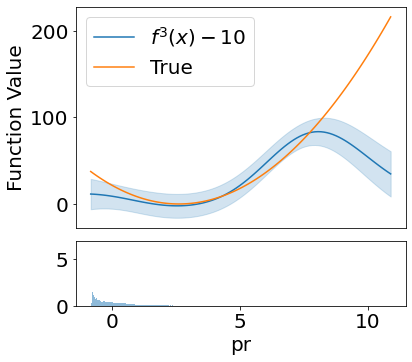

In [ ]:
x_pr_original = X_train[:,3]
x_pr_plot = np.linspace(-5, 12, 100)[:, None]
f_mean, f_var = m.predict_f_i(x_pr_plot, 2)
from matplotlib.gridspec import GridSpec
pars = {"size": 20}
plt.rc("font", **pars)
fig = plt.figure(figsize=(8, 5.5))
gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[0:3,0:3])
ax_marg_x = fig.add_subplot(gs[3,0:3])
constant_bias = 0
ax_joint.plot(x_pr_plot, scaler_y.inverse_transform(f_mean)-constant_bias, label=f"$f^3(x) - 10$")
ax_joint.fill_between(
    x_pr_plot[:,0],
    scaler_y.inverse_transform(f_mean - 1.96 * np.sqrt(f_var))[:, 0]-constant_bias,
    scaler_y.inverse_transform(f_mean + 1.96 * np.sqrt(f_var))[:, 0]-constant_bias,
    color="C0",
    alpha=0.2,
)
ax_joint.plot(x_pr_plot, 1.5*x_pr_plot**2, label="True") # note the constant bias
ax_joint.legend()
ax_joint.get_xaxis().set_ticks([])
ax_joint.set_ylabel("Function Value")
ax_marg_x.hist(x_pr_original, bins=500, alpha=0.5, density=True)
ax_marg_x.set_xlabel("pr")

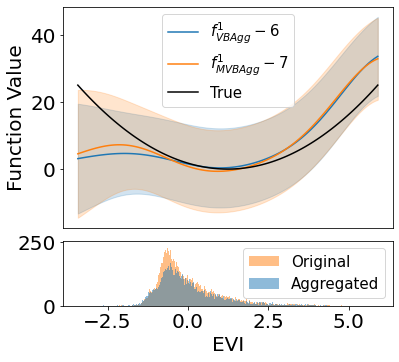

In [13]:
x_modis_original = X_train[:,2]
x_modis_plot = np.linspace(-5, 5, 100)[:, None]
f_mean, f_var = m.predict_f_i(x_modis_plot, 1)
from matplotlib.gridspec import GridSpec
pars = {"size": 20}
plt.rc("font", **pars)
fig = plt.figure(figsize=(8, 5.5))
gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[0:3,0:3])
ax_marg_x = fig.add_subplot(gs[3,0:3])
ax_joint.plot(x_modis_plot, scaler_y.inverse_transform(f_mean)-6, label="$f_{VBAgg}^1 - 6$", color="C0")
ax_joint.fill_between(
    x_modis_plot[:,0],
    scaler_y.inverse_transform(f_mean - 1.96 * np.sqrt(f_var))[:, 0]-6,
    scaler_y.inverse_transform(f_mean + 1.96 * np.sqrt(f_var))[:, 0]-6,
    color="C0",
    alpha=0.2,
)

ax_joint.plot(x_modis, scaler_y.inverse_transform(f_mean_modis)-7, label="$f_{MVBAgg}^1 - 7$", color="C1")
ax_joint.fill_between(
    x_modis[:,0],
    scaler_y.inverse_transform(f_mean_modis - 1.96 * np.sqrt(f_var_modis))[:, 0]-7,
    scaler_y.inverse_transform(f_mean_modis + 1.96 * np.sqrt(f_var_modis))[:, 0]-7,
    color="C1",
    alpha=0.2,
)
ax_joint.plot(x_modis_plot, 1*x_modis_plot**2, label="True", color="black") # note the constant bias
ax_joint.legend(prop={"size": 15})
ax_joint.get_xaxis().set_ticks([])
ax_joint.set_ylabel("Function Value")
ax_marg_x.hist(X_modis_train[:,0], bins=1000, alpha=0.5, label="Original", color="C1")
ax_marg_x.hist(x_modis_original, bins=1000, alpha=0.5, label="Aggregated", color="C0")
ax_marg_x.set_xlabel("EVI")
ax_marg_x.legend(prop={"size": 15})
plt.savefig("../../results/synthetic/EVI_disagg_comparison.pdf")